In [1]:
# ===============================================
# 0️⃣ Kütüphaneler
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# Preprocessed veri
df = pd.read_csv('return_risk_final_dataset.csv')

# Eğitilmiş RF modeli
with open('rf_return_risk_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

print("✅ Veri ve model yüklendi, shape:", df.shape)


✅ Veri ve model yüklendi, shape: (10000, 7)


In [4]:
IMPORTANT_FEATURES = [
    'Days_to_Return',
    'Return_Risk_Category',
    'Discount_Applied',
    'Product_Price',
    'Total_Sale_Amount',
    'Net_Sale_Amount'
]

X = df[IMPORTANT_FEATURES].copy()
y = df['Returned'].astype(int)

# Kategorik -> sayısal
X['Return_Risk_Category'] = X['Return_Risk_Category'].astype('category').cat.codes



=== Test Seti Sınıflandırma Raporu ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1484
           1       1.00      1.00      1.00      1516

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



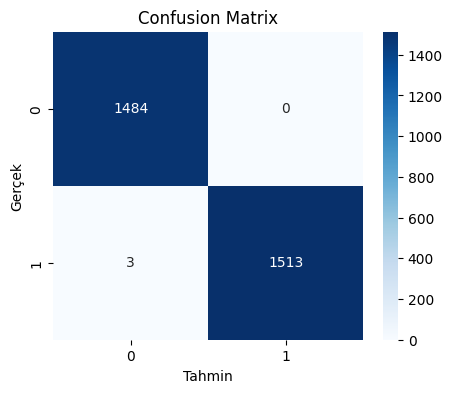

In [5]:
# Eğitim/Test split (opsiyonel)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Tahmin
y_pred = rf_model.predict(X_test)

# Rapor
print("\n=== Test Seti Sınıflandırma Raporu ===")
print(classification_report(y_test, y_pred))

# Confusion matrix görselleştirme
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()



=== Feature Importance ===
                Feature  Importance
0        Days_to_Return    0.696233
1  Return_Risk_Category    0.299065
5       Net_Sale_Amount    0.001477
2      Discount_Applied    0.001455
3         Product_Price    0.000925
4     Total_Sale_Amount    0.000845


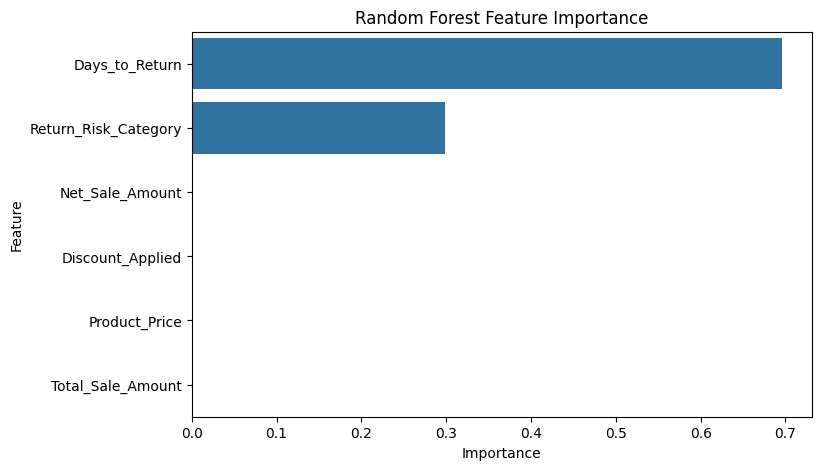

In [6]:
feat_importances = pd.DataFrame({
    'Feature': IMPORTANT_FEATURES,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importance ===")
print(feat_importances)

# Görselleştirme
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Random Forest Feature Importance')
plt.show()


In [7]:
# Tahminleri ekle
df['Return_Risk_Predicted'] = rf_model.predict(X)

# Risk kategorilerine göre gruplama
risk_summary = df.groupby('Return_Risk_Predicted')['Returned'].agg(['count', 'mean']).reset_index()
risk_summary.columns = ['Risk_Predicted', 'Order_Count', 'Return_Rate']
print(risk_summary)


   Risk_Predicted  Order_Count  Return_Rate
0               0         4954     0.001211
1               1         5046     1.000000


In [8]:
def predict_return_risk(new_df, model, features):
    X_new = new_df[features].copy()
    X_new['Return_Risk_Category'] = X_new['Return_Risk_Category'].astype('category').cat.codes
    return model.predict(X_new)


In [13]:
# ===============================================
# 0️⃣ Kütüphaneler
# ===============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer

# ===============================================
# 1️⃣ Veri Yükleme (Colab veya manuel yükleme)
# ===============================================
from google.colab import files
uploaded = files.upload()  # CSV yükleme penceresi açılır

# Yüklenen dosyayı dataframe'e aktar
df = pd.read_csv(list(uploaded.keys())[0])
df.columns = df.columns.str.strip()
print("✅ Veri yüklendi, shape:", df.shape)

# ===============================================
# 2️⃣ Önemli Feature'lar
# ===============================================
IMPORTANT_FEATURES = [
    'Days_to_Return',
    'Return_Risk_Category',
    'Discount_Applied',
    'Product_Price',
    'Total_Sale_Amount',
    'Net_Sale_Amount'
]

X = df[IMPORTANT_FEATURES].copy()
y = df['Returned'].astype(int)

# ===============================================
# 3️⃣ Eksik değerleri doldur
# ===============================================
num_cols = ['Days_to_Return', 'Discount_Applied', 'Product_Price', 'Total_Sale_Amount', 'Net_Sale_Amount']
imputer_num = SimpleImputer(strategy='median')
X[num_cols] = imputer_num.fit_transform(X[num_cols])

cat_cols = ['Return_Risk_Category']
imputer_cat = SimpleImputer(strategy='most_frequent')
X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])

# Kategorik kolon -> sayısal
X['Return_Risk_Category'] = X['Return_Risk_Category'].astype('category').cat.codes

# ===============================================
# 4️⃣ Eğitim / Test Seti
# ===============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===============================================
# 5️⃣ SMOTE + Undersampling ile sınıf dengesi
# ===============================================
sm = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)
X_res, y_res = rus.fit_resample(X_res, y_res)

print("✅ Sınıf dengesi sağlandı:", dict(zip(*np.unique(y_res, return_counts=True))))

# ===============================================
# 6️⃣ Random Forest Modeli Eğitimi
# ===============================================
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

rf_model.fit(X_res, y_res)
print("✅ RF modeli başarıyla eğitildi!")

# ===============================================
# 7️⃣ Test Seti Tahminleri ve Rapor
# ===============================================
y_pred = rf_model.predict(X_test)

print("\n=== Test Seti Raporu ===")
print(classification_report(y_test, y_pred))
print("\n=== Karışıklık Matrisi ===")
print(confusion_matrix(y_test, y_pred))

# ===============================================
# 8️⃣ Feature Importance
# ===============================================
importances = pd.DataFrame({
    'Feature': IMPORTANT_FEATURES,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importance ===")
print(importances)


Saving return_risk_final_dataset.csv to return_risk_final_dataset (1).csv
✅ Veri yüklendi, shape: (10000, 7)
✅ Sınıf dengesi sağlandı: {np.int64(0): np.int64(3536), np.int64(1): np.int64(3536)}
✅ RF modeli başarıyla eğitildi!

=== Test Seti Raporu ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1484
           1       1.00      1.00      1.00      1516

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


=== Karışıklık Matrisi ===
[[1484    0]
 [   3 1513]]

=== Feature Importance ===
                Feature  Importance
0        Days_to_Return    0.842465
1  Return_Risk_Category    0.150331
5       Net_Sale_Amount    0.002363
2      Discount_Applied    0.001819
4     Total_Sale_Amount    0.001733
3         Product_Price    0.001290



=== Müşteri Segmentleri ve Return Rate ===
                       Order_Count  Return_Count  Return_Rate
Return_Risk_Predicted                                        
0                             4951             3     0.000606
1                             5049          5049     1.000000


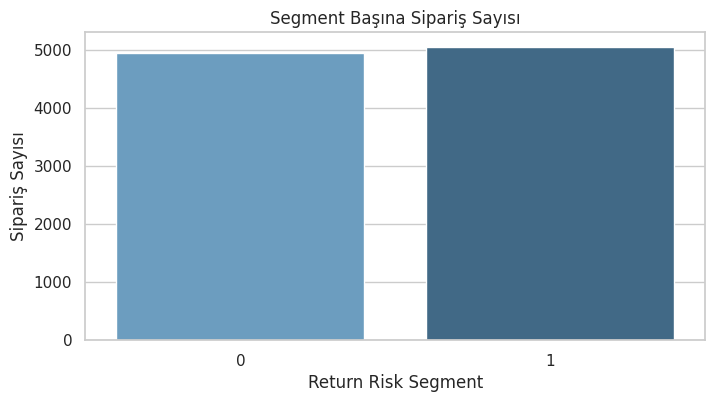

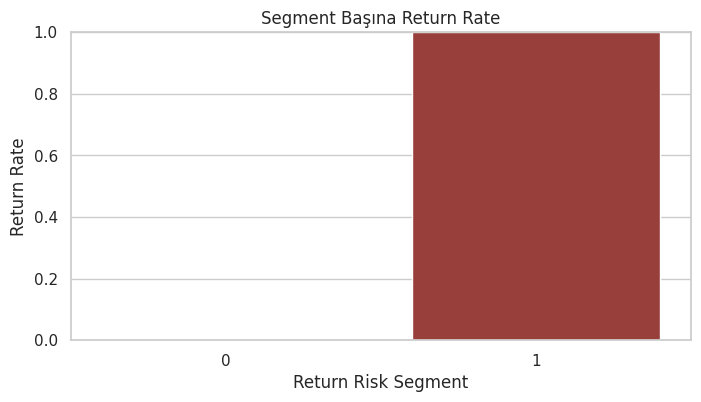

In [14]:
# ===============================================
# 9️⃣ Tahminleri veri setine ekle
# ===============================================
df['Return_Risk_Predicted'] = rf_model.predict(X)

# ===============================================
# 🔹 Müşteri Segmentasyonu ve Return Rate
# ===============================================
# Segmentleri risk kategorisine göre belirle
segments = df.groupby('Return_Risk_Predicted').agg(
    Order_Count=('Returned', 'count'),
    Return_Count=('Returned', 'sum')
)
segments['Return_Rate'] = segments['Return_Count'] / segments['Order_Count']

print("\n=== Müşteri Segmentleri ve Return Rate ===")
print(segments)

# ===============================================
# 🔹 Görselleştirme
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Sipariş sayısı bar chart
plt.figure(figsize=(8,4))
sns.barplot(x=segments.index, y=segments['Order_Count'], palette='Blues_d')
plt.title('Segment Başına Sipariş Sayısı')
plt.xlabel('Return Risk Segment')
plt.ylabel('Sipariş Sayısı')
plt.show()

# Return Rate bar chart
plt.figure(figsize=(8,4))
sns.barplot(x=segments.index, y=segments['Return_Rate'], palette='Reds_d')
plt.title('Segment Başına Return Rate')
plt.xlabel('Return Risk Segment')
plt.ylabel('Return Rate')
plt.ylim(0,1)
plt.show()



=== Müşteri Segmentleri ve Return Rate ===
                       Order_Count  Return_Count  Return_Rate
Return_Risk_Predicted                                        
0                             4951             3     0.000606
1                             5049          5049     1.000000


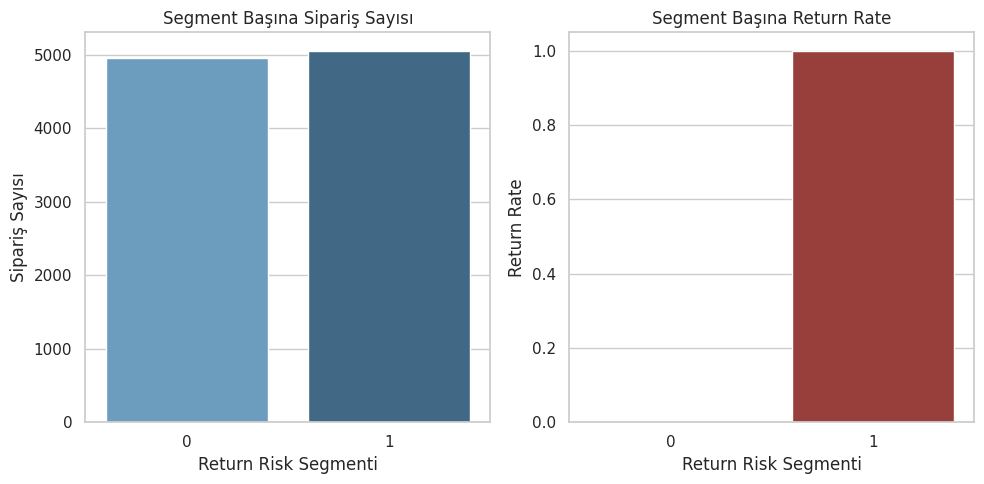

In [15]:
# ===============================================
# 3️⃣ Müşteri Segmentasyonu ve Return Rate
# ===============================================
segment_summary = df.groupby('Return_Risk_Predicted').agg(
    Order_Count=('Returned', 'count'),
    Return_Count=('Returned', 'sum')
)
segment_summary['Return_Rate'] = segment_summary['Return_Count'] / segment_summary['Order_Count']

print("\n=== Müşteri Segmentleri ve Return Rate ===")
print(segment_summary)

# ===============================================
# 4️⃣ Görselleştirme
# ===============================================
plt.figure(figsize=(10,5))

# Sipariş sayısı
plt.subplot(1,2,1)
sns.barplot(x=segment_summary.index, y='Order_Count', data=segment_summary, palette='Blues_d')
plt.title('Segment Başına Sipariş Sayısı')
plt.xlabel('Return Risk Segmenti')
plt.ylabel('Sipariş Sayısı')

# Return Rate
plt.subplot(1,2,2)
sns.barplot(x=segment_summary.index, y='Return_Rate', data=segment_summary, palette='Reds_d')
plt.title('Segment Başına Return Rate')
plt.xlabel('Return Risk Segmenti')
plt.ylabel('Return Rate')

plt.tight_layout()
plt.show()